# SPARK Dataset


## Imports

In [1]:
from spark_utils import PyTorchSparkDataset, SPARKDataset
from matplotlib import pyplot as plt
from random import randint
import os

# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [2]:
import torch
import torchvision
from torchvision.transforms import v2 as T
from torchvision.transforms.v2 import functional as F
from torchvision import tv_tensors
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from engine import train_one_epoch, evaluate

# We are using BETA APIs, so we deactivate the associated warning, thereby acknowledging that
# some APIs may slightly change in the future
torchvision.disable_beta_transforms_warning()


## Defining the Dataset

By default, the output structure of the dataset is not compatible with the models or the transforms (https://pytorch.org/vision/master/transforms.html#v1-or-v2-which-one-should-i-use). To overcome that, we wrap a `PyTorchSparkDataset` in`PyTorchSparkDatasetV2`.

In the code below, we are wrapping images and bounding boxes `torchvision.TVTensor classes` so that we will be able to apply torchvision built-in transformations for the given object detection and segmentation task. Namely, image tensors will be wrapped by `torchvision.tv_tensors.Image` and bounding boxes into `torchvision.tv_tensors.BoundingBoxes`. Our dataset now returns a target which is dict where the values are `TVTensors` (all are `torch.Tensor` subclasses).

We also make the dataset compliant with COCO requirements so that it will work for both training and evaluation codes from the COCO reference script.

In [3]:
# Wrap a PyTorchSparkDataset dataset for usage with torchvision.transforms.v2
class PyTorchSparkDatasetV2(torch.utils.data.Dataset):
    def __init__(
        self,
        class_map,
        split="train",
        root_dir="./data/",
        transforms=None,
        sample_size=1,
    ):
        self.dataset = PyTorchSparkDataset(
            class_map, split=split, root_dir=root_dir, sample_size=sample_size
        )
        self.transforms = transforms
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        if self.split == "test":
            img, img_name = self.dataset[idx]
            img = tv_tensors.Image(img)

            if self.transforms is not None:
                img = self.transforms(img)

            return img, img_name

        else:
            img, label, bbox = self.dataset[idx]

            img = tv_tensors.Image(img)

            bbox = tv_tensors.BoundingBoxes(
                bbox, format=tv_tensors.BoundingBoxFormat.XYXY, canvas_size=F.get_size(img)
            )
            label = torch.tensor([label])
            area = (bbox[:, 3] - bbox[:, 1]) * (bbox[:, 2] - bbox[:, 0])
            iscrowd = torch.zeros((1,), dtype=torch.int64)
            image_id = idx

            target = {
                "boxes": bbox,
                "labels": label,
                "area": area,
                "iscrowd": iscrowd,
                "image_id": image_id,
            }

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target


## Transforms

Let’s now define our pre-processing transforms. All the transforms know how to handle images, bouding boxes and masks when relevant.

Transforms are typically passed as the transforms parameter of the dataset so that they can leverage multi-processing from the `torch.utils.data.DataLoader`.

If the data is intended for training, a series of augmentation techniques are used. These include `RandomPhotometricDistort` to apply random color distortions (this helps the model generalize better across varying lighting conditions), and `RandomZoomOut` which randomly zooms out of the image (creating new perspectives and scales for the model to learn from).

The `RandomIoUCrop` performs a random crop based on the intersection-over-union (IoU) of the bounding boxes, and `RandomHorizontalFlip` and `RandomVerticalFlip` randomly flips the image horizontally and vertically (increasing the diversity of orientations). The `SanitizeBoundingBoxes` function adjusts and sanitizes the bounding boxes after these transformations are applied.

- http://pytorch.org/vision/main/auto_examples/transforms/plot_transforms_e2e.html#transforms-v2-end-to-end-object-detection-segmentation-example
- https://pytorch.org/vision/stable/auto_examples/transforms/plot_transforms_getting_started.html#sphx-glr-auto-examples-transforms-plot-transforms-getting-started-py

In [4]:
# Define the transforms to be applied to the data.
def get_transform(split):
    """Defines tranforms for datasets."""
    transforms = []
    transforms.append(T.ToImage())

    if split == "train":
        transforms.append(T.RandomPhotometricDistort(p=0.5))
        transforms.append(
            T.RandomZoomOut(fill={tv_tensors.Image: (123, 117, 104), "others": 0})
        )
        transforms.append(T.RandomIoUCrop())
        transforms.append(T.RandomHorizontalFlip(p=0.5))
        transforms.append(T.RandomVerticalFlip(p=0.5))
        # transforms.append(T.Resize((64, 64)))
        transforms.append(T.SanitizeBoundingBoxes())

    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())

    return T.Compose(transforms)


## Loading Datasets

In [5]:
def get_dataset(split, class_map, data_path, sample_size=1):
    """Returns dataset."""
    # We use the PyTorchSparkDatasetV2 class defined above.
    dataset = PyTorchSparkDatasetV2(
        class_map=class_map,
        split=split,
        root_dir=data_path,
        transforms=get_transform(split),
        sample_size=sample_size,
    )
    return dataset


In [6]:
# Set up the path to a local copy of the SPARK dataset, labels csv files should be in the same directory.
# The image sets should be in /data/train, /data/validation and /data/test.
data_path = "./data/"

# Define the class map, this is a dictionary that maps the class names to integer labels.
class_map = {
    "background": 0,
    "proba_2": 1,
    "cheops": 2,
    "debris": 3,
    "double_star": 4,
    "earth_observation_sat_1": 5,
    "lisa_pathfinder": 6,
    "proba_3_csc": 7,
    "proba_3_ocs": 8,
    "smart_1": 9,
    "soho": 10,
    "xmm_newton": 11,
}

# Define the number of classes
num_classes = len(class_map)


In [7]:
# # Define the datasets for training and validation
dataset = get_dataset(
    split="train", class_map=class_map, data_path=data_path, sample_size=0.1
)
dataset_valid = get_dataset(
    split="validation", class_map=class_map, data_path=data_path, sample_size=0.1
)

print(f"Number of training samples: {len(dataset)}")
print(f"Number of validation samples: {len(dataset_valid)}\n")


Number of training samples: 6600
Number of validation samples: 2200



In [8]:
# Check dataset format for debugging purposes
sample = dataset[0]
image, target = sample

print(f"Image type: {type(image)}")
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")
print()
print(f"Target type: {type(target)}")
print("Target keys: ", list(target.keys()))
print()
print(f"Boxes type: {type(target['boxes'])}")
print(f"Boxes shape: {target['boxes'].shape}")
print()
print(f"Labels type: {type(target['labels'])}")
print(f"Labels shape: {target['labels'].shape}")
print(f"Labels dtype: {target['labels'].dtype}")


Image type: <class 'torch.Tensor'>
Image shape: torch.Size([3, 555, 418])
Image dtype: torch.float32

Target type: <class 'dict'>
Target keys:  ['boxes', 'labels', 'area', 'iscrowd', 'image_id']

Boxes type: <class 'torch.Tensor'>
Boxes shape: torch.Size([1, 4])

Labels type: <class 'torch.Tensor'>
Labels shape: torch.Size([1])
Labels dtype: torch.int64


## Visualizing Images

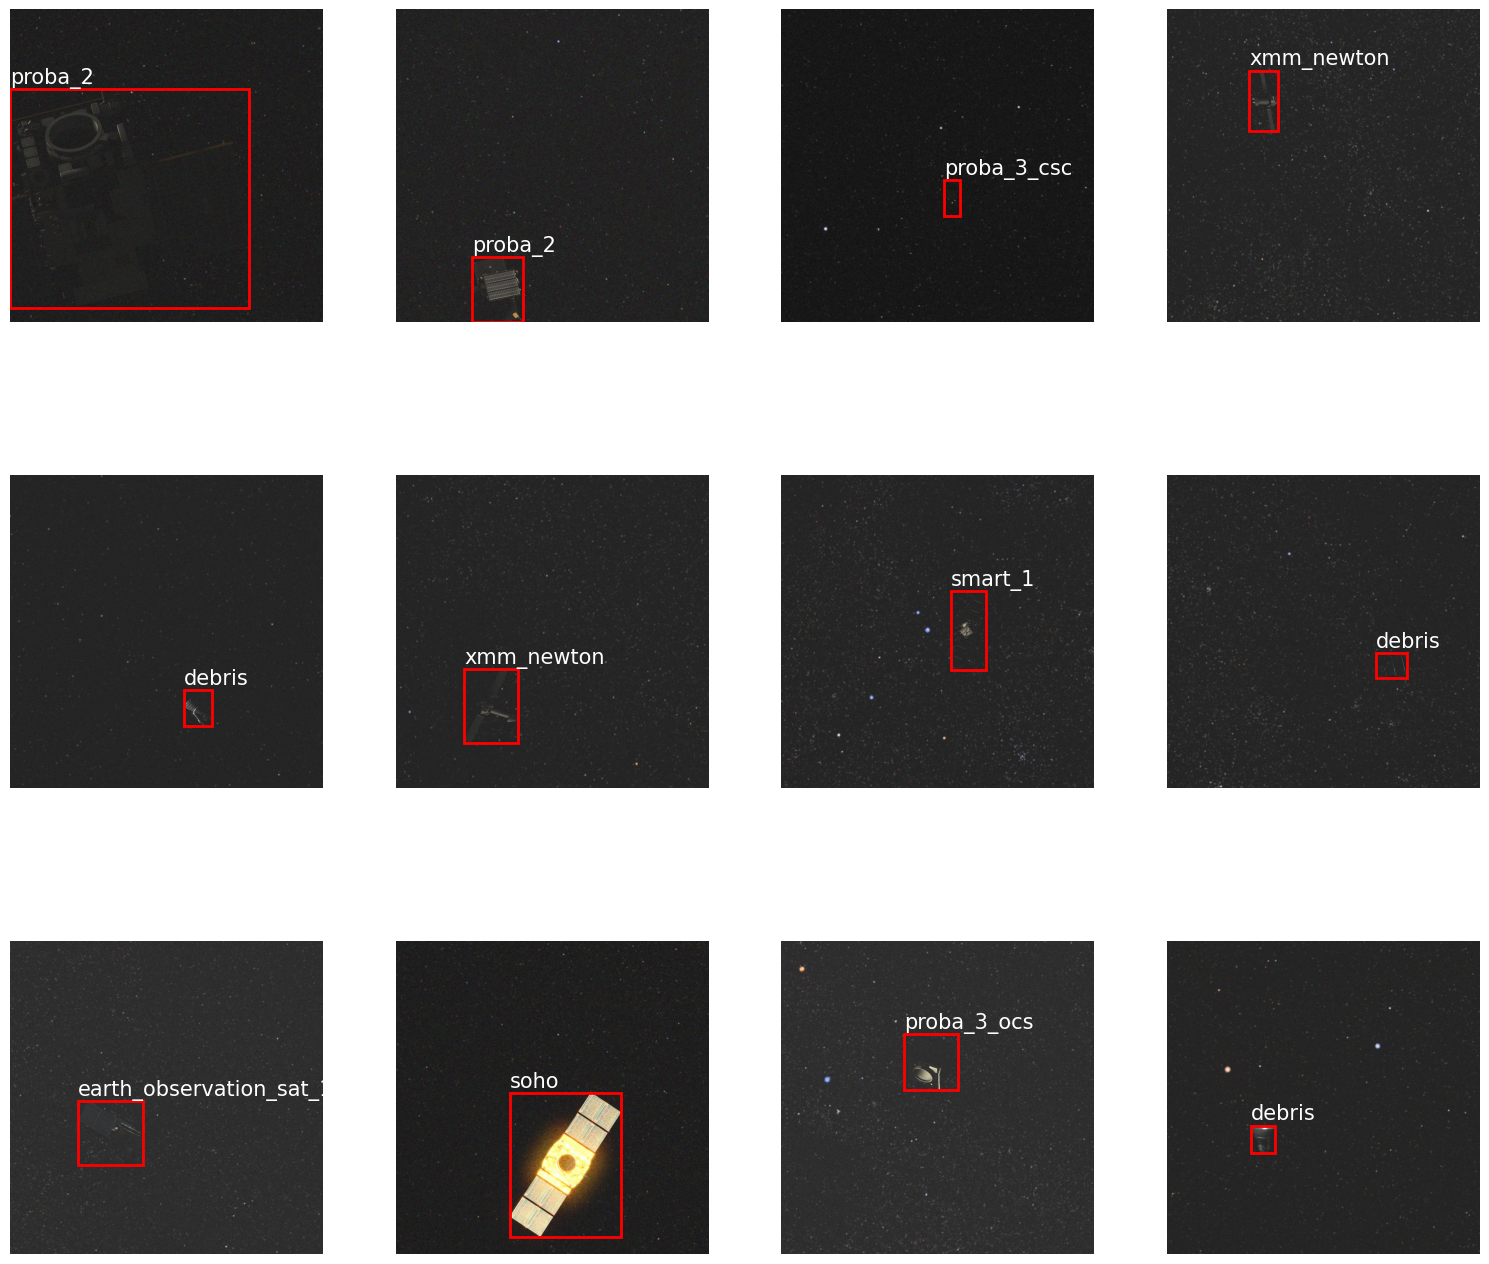

In [9]:
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Note that we are using the SPARKDataset class here instead of the PyTorchSparkDatasetV2 class
ds = SPARKDataset(class_map, root_dir=data_path, split="train")

for i in range(rows):
    for j in range(cols):
        ds.visualize(randint(0, len(ds)), size=(10, 10), ax=axes[i][j])
        axes[i][j].axis("off")

fig.tight_layout()


## Define Dataloaders

In [10]:
# Define the batch size to be used.
batch_size = 4

# Define the dataloaders for training, validation and testing.
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)

data_loader_valid = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=lambda batch: tuple(zip(*batch)),
)


## Defining Model

We will be using Faster R-CNN V2. Faster R-CNN V2 is a model that predicts both bounding boxes and class scores for potential objects in the image. It works similarly to Faster R-CNN with ResNet-50 FPN backbone.

We will start from a model pre-trained on COCO and finetune it for our particular classes in order to perform transfer learning.

- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn_v2.html
- https://pytorch.org/vision/main/models/generated/torchvision.models.detection.fasterrcnn_resnet50_fpn.html
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [11]:
# Define the model
def get_model_instance_segmentation(num_classes):
    # Load an instance segmentation model pre-trained on COCO
    # TODO: Experiment with other weights such as 'COCO_V1'
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")
    # Get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model


## Model Training

Below is the main function which performs the training and the validation.

Run the cell below if you have an error "CUDA is out of memory"

In [12]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [13]:
# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# Move model to the right device
model.to(device)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

If you have saved a checkpoint, you can load it and resume training from there. Otherwise, the model will be trained from scratch.

In [17]:
# Load the state dict previously saved
checkpoint = torch.load("model_4.pth")
model.load_state_dict(checkpoint["model_state_dict"])
start_epoch = 5
metrics = evaluate(model, data_loader_valid, device=device)

creating index...
index created!
Test:  [  0/550]  eta: 0:02:14  model_time: 0.1658 (0.1658)  evaluator_time: 0.0043 (0.0043)  time: 0.2437  data: 0.0610  max mem: 2513
Test:  [100/550]  eta: 0:01:41  model_time: 0.1545 (0.1544)  evaluator_time: 0.0026 (0.0031)  time: 0.2215  data: 0.0520  max mem: 2513
Test:  [200/550]  eta: 0:01:18  model_time: 0.1551 (0.1547)  evaluator_time: 0.0036 (0.0031)  time: 0.2257  data: 0.0549  max mem: 2513
Test:  [300/550]  eta: 0:00:56  model_time: 0.1554 (0.1549)  evaluator_time: 0.0028 (0.0030)  time: 0.2281  data: 0.0575  max mem: 2513
Test:  [400/550]  eta: 0:00:33  model_time: 0.1554 (0.1551)  evaluator_time: 0.0029 (0.0030)  time: 0.2238  data: 0.0531  max mem: 2513
Test:  [500/550]  eta: 0:00:11  model_time: 0.1555 (0.1552)  evaluator_time: 0.0029 (0.0031)  time: 0.2276  data: 0.0570  max mem: 2513
Test:  [549/550]  eta: 0:00:00  model_time: 0.1553 (0.1552)  evaluator_time: 0.0031 (0.0031)  time: 0.2227  data: 0.0516  max mem: 2513
Test: Total tim

In [14]:
# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# And a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# Let's train it for 5 epochs
num_epochs = 5

for epoch in range(start_epoch, start_epoch + num_epochs):
    print(f"Epoch {epoch} in progress..")
    # Train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=100)
    # Update the learning rate
    lr_scheduler.step()
    # Evaluate on the test dataset
    evaluate(model, data_loader_valid, device=device)
    # Save the model after each epoch
    torch.save({ 'epoch': epoch, 'model_state_dict': model.state_dict()}, f'model_{epoch}.pth')


NameError: name 'start_epoch' is not defined

## Compute Predictions

In [19]:
dataset_test = get_dataset(
    split="test", class_map=class_map, data_path=data_path
)

print(f"Number of test samples: {len(dataset_test)}\n")


Number of test samples: 22000



In [20]:
data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=lambda batch: tuple(zip(*batch)),
)


In [21]:
# Switch the model to evaluation mode
model.eval()


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       

Each image processed by the model could potentially have multiple bounding boxes predicted, each with a confidence score. However, in this script, we've implemented a strategy to keep the prediction process simple and focused. Instead of considering multiple bounding boxes per image, we only take the bounding box with the highest confidence score. This means that for each image, we are predicting a single bounding box, that is, the one that the model is most certain about.

The script also handles cases where no bounding boxes are predicted for an image. In such cases, it records an empty bounding box and class label.


In [22]:
def get_inverse_class_map(class_map):
    """Returns a dictionary that maps integer labels to class names."""
    return {v: k for k, v in class_map.items()}

# Create the inverse class map.
inverse_class_map = get_inverse_class_map(class_map)

def process_predictions(predictions):
    """Processes predictions to keep only the bounding box with the highest score."""
    for i, prediction in enumerate(predictions):
        if prediction['scores'].numel() > 0:
            max_score_index = prediction['scores'].argmax()
            predictions[i] = {key: val[max_score_index].unsqueeze(0) for key, val in prediction.items()}
    return predictions

def write_prediction_to_file(f, prediction, img_name):
    """Writes a single prediction to the file."""
    if prediction['scores'].numel() > 0:
        box = list(map(int, prediction["boxes"].cpu().numpy().squeeze()))
        label = int(prediction["labels"].cpu().numpy().squeeze())
        class_name = inverse_class_map[label]  # Convert the integer label to a class name.
        box_str = str(box)  # Convert the bounding box coordinates to a string.
    else:
        # TODO: Replace by background class name and full size of image
        box_str, class_name = '', ''

    f.write(f'{img_name},{class_name},"{box_str}"\n')


The predictions are then written to a CSV file, with each line in the file corresponding to one image from the test dataset. Each line contains the image name, the predicted class label, and the coordinates of the predicted bounding box.


In [ ]:
# Define the CSV file path
csv_file_path = os.path.join(data_path, 'predictions.csv')

# Open the CSV file and write the header
with open(csv_file_path, "w") as f:
    f.write("filename,class,bbox\n")

# Loop over the test dataset
for i, (images, img_names) in enumerate(data_loader_test):

    # Move the images to the device
    images = [image.to(device) for image in images]

    # Compute the model predictions
    with torch.no_grad():
        predictions = model(images)

    # Process predictions to keep only the bounding box with the highest score
    predictions = process_predictions(predictions)

    # Open the CSV file in append mode and write the predictions
    with open(csv_file_path, "a") as f:
        for prediction, img_name in zip(predictions, img_names):
            write_prediction_to_file(f, prediction, img_name)


## Visualizing Predictions

What do the predictions look like? Let’s take a look at some images in the dataset and verify

In [ ]:
rows, cols = 3, 4
fig, axes = plt.subplots(rows, cols, figsize=(15, 15))

# Note that we are using the SPARKDataset class here instead of the PyTorchSparkDatasetV2 class
ds = SPARKDataset(class_map, root_dir=data_path, split="predictions")

for i in range(rows):
    for j in range(cols):
        ds.visualize(randint(0, len(ds)), size=(10, 10), ax=axes[i][j])
        axes[i][j].axis("off")

fig.tight_layout()


In [1]:
# Data visualization

In [19]:
# Lists to store AP and AR values for each epoch
ap_values = {"all50-95": [], "all50": [], "all75": [], "small": [], "medium": [], "large": []}
ar_values = {"all50-95": [], "small": [], "medium": [], "large": []}

for epoch in range(8):
    # Load the saved model state
    model_path = f'model_{epoch}.pth'

    if(epoch < 3):
        model.load_state_dict(torch.load(model_path))
    else:
        checkpoint = torch.load(model_path)
        model.load_state_dict(checkpoint["model_state_dict"])

    print(f"model_{epoch}.pth loaded!")

    # Evaluate on the validation dataset
    metrics = evaluate(model, data_loader_valid, device=device)

    print(f"\nMetrics for Epoch {epoch + 1}:")

    # Access the stats array from metrics.coco_eval["bbox"]
    stats = metrics.coco_eval["bbox"].stats

    ap_values["all50-95"].append(stats[0])
    ap_values["all50"].append(stats[1])
    ap_values["all75"].append(stats[2])
    ap_values["small"].append(stats[3])
    ap_values["medium"].append(stats[4])
    ap_values["large"].append(stats[5])
    ar_values["all50-95"].append(stats[8]) # Don't use all50-95 with 1 and 10 detections
    ar_values["small"].append(stats[9])
    ar_values["medium"].append(stats[10])
    ar_values["large"].append(stats[11])


model_0.pth loaded!
creating index...
index created!
Test:  [  0/550]  eta: 0:02:11  model_time: 0.1657 (0.1657)  evaluator_time: 0.0065 (0.0065)  time: 0.2398  data: 0.0556  max mem: 2338
Test:  [100/550]  eta: 0:01:38  model_time: 0.1501 (0.1503)  evaluator_time: 0.0036 (0.0042)  time: 0.2144  data: 0.0486  max mem: 2338
Test:  [200/550]  eta: 0:01:16  model_time: 0.1506 (0.1504)  evaluator_time: 0.0051 (0.0045)  time: 0.2185  data: 0.0507  max mem: 2338
Test:  [300/550]  eta: 0:00:54  model_time: 0.1513 (0.1506)  evaluator_time: 0.0051 (0.0045)  time: 0.2214  data: 0.0530  max mem: 2338
Test:  [400/550]  eta: 0:00:32  model_time: 0.1512 (0.1508)  evaluator_time: 0.0044 (0.0046)  time: 0.2172  data: 0.0495  max mem: 2338
Test:  [500/550]  eta: 0:00:10  model_time: 0.1513 (0.1509)  evaluator_time: 0.0041 (0.0045)  time: 0.2195  data: 0.0522  max mem: 2338
Test:  [549/550]  eta: 0:00:00  model_time: 0.1512 (0.1509)  evaluator_time: 0.0044 (0.0045)  time: 0.2147  data: 0.0471  max mem: 

In [25]:
ap_values
#ap_values.pop("small")

{'all50-95': [0.4735069491557952,
  0.5647391778631327,
  0.621628282133048,
  0.6380283725106143,
  0.6561030701032199,
  0.6683414697585711,
  0.679878631245619,
  0.6415619786438546],
 'all50': [0.7485043223039433,
  0.8641245107411422,
  0.9051743656081191,
  0.9093342012919899,
  0.9306382547913283,
  0.930108317556888,
  0.9401286948774811,
  0.9259775662435299],
 'all75': [0.5432117302167827,
  0.6651151964134785,
  0.7390284083850263,
  0.756469806925076,
  0.7773790060608773,
  0.778151645416073,
  0.7862727191176712,
  0.7551067448822355],
 'medium': [0.31188126445259434,
  0.45159399924400695,
  0.5091623264940769,
  0.5077190081905012,
  0.5323476677717233,
  0.5591465376330522,
  0.5368252436791308,
  0.5519422425247863],
 'large': [0.48707438994363644,
  0.5762039940509287,
  0.6390750464065276,
  0.6538011110604365,
  0.6712729315135585,
  0.6855471560083142,
  0.6971752904116759,
  0.6593372052050465]}

In [23]:
ar_values
# ar_values.pop("small")

{'all50-95': [0.6284545454545454,
  0.6686363636363636,
  0.7114545454545453,
  0.7130454545454543,
  0.7260909090909092,
  0.7387272727272727,
  0.7498636363636364,
  0.7223636363636363],
 'medium': [0.5716074299737666,
  0.5351929487066354,
  0.6246317156602538,
  0.6066329782299497,
  0.6526696733021718,
  0.6471521210944623,
  0.6643067614453753,
  0.615985644718318],
 'large': [0.6434491230940648,
  0.6839171489260046,
  0.726099564575178,
  0.7270692143640145,
  0.737566793838408,
  0.7529722520951172,
  0.7649288569501255,
  0.7391534305670138]}

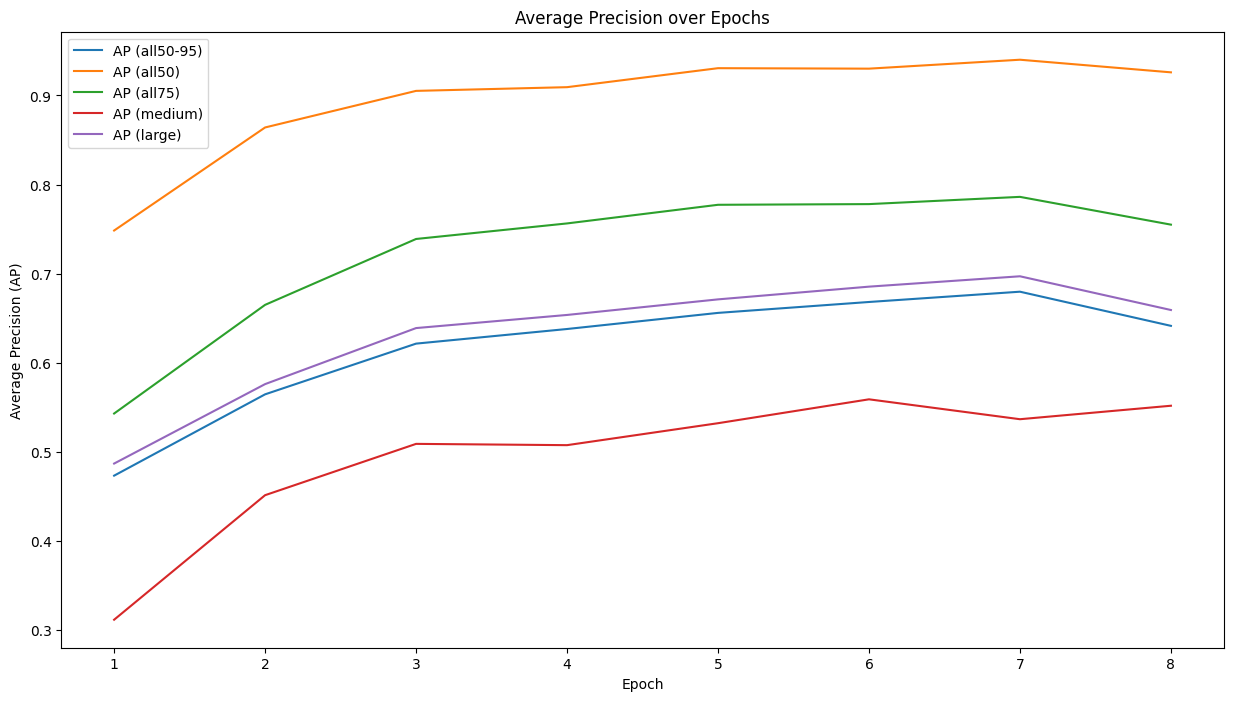

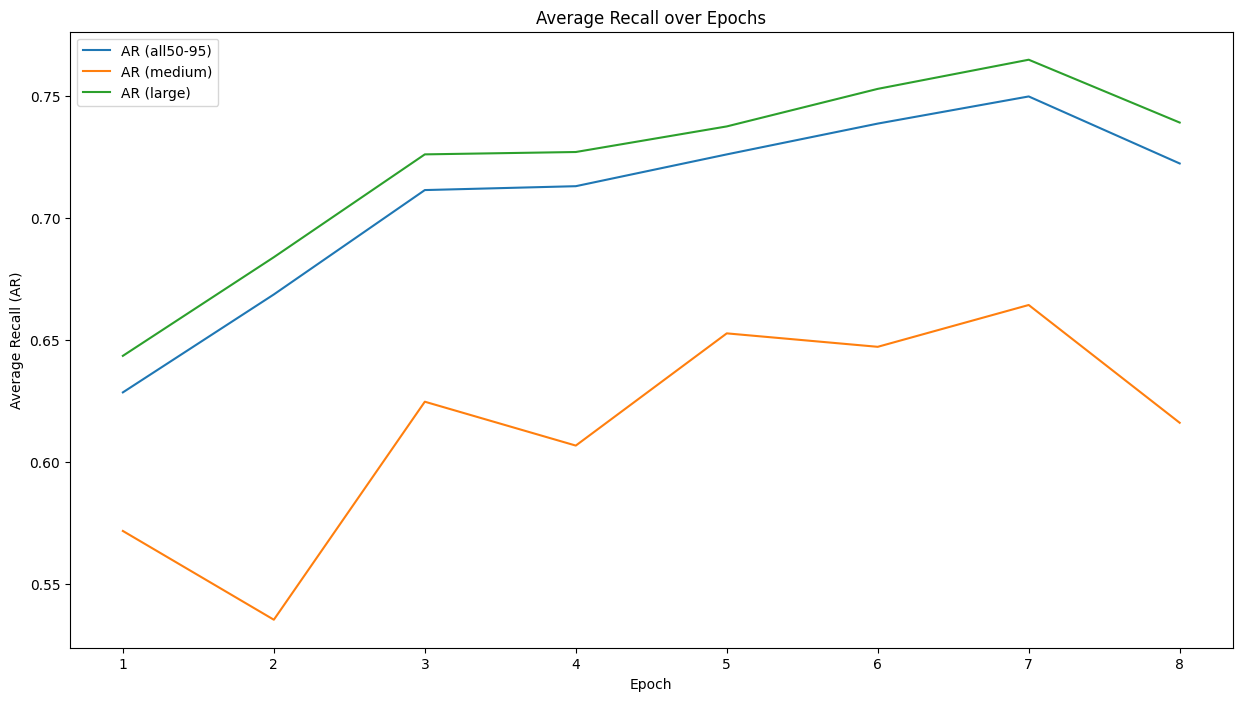

In [34]:
import matplotlib.pyplot as plt

# Plotting Average Precision values
plt.figure(figsize=(15, 8))
for area, values in ap_values.items():
    plt.plot(range(1, 9), values, label=f"AP ({area})")

plt.xticks(range(1, 9))
plt.xlabel("Epoch")
plt.ylabel("Average Precision (AP)")
plt.title("Average Precision over Epochs")
plt.legend()
plt.show()

# Plotting Average Recall values
plt.figure(figsize=(15, 8))
for area, values in ar_values.items():
    plt.plot(range(1, 9), values, label=f"AR ({area})")

plt.xticks(range(1, 9))
plt.xlabel("Epoch")
plt.ylabel("Average Recall (AR)")
plt.title("Average Recall over Epochs")
plt.legend()
plt.show()